<a href="https://colab.research.google.com/github/wangyuyyt/rubik_cube_solver/blob/main/Rubik's_Cube_color_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
base_drive_dir = '/content/gdrive/My Drive/Colab Notebooks/Rubic cube color classification'
training_data_dir = os.path.join(base_drive_dir, 'training data')
version = 'v4-7'
model_dir = os.path.join(base_drive_dir, 'models')
model_name = os.path.join(model_dir,'color_detection-' + version + '.h5')
dt_model_name = os.path.join(model_dir, 'decision_tree-' + version + '.joblib')
history_path = os.path.join(model_dir,'color_detection-' + version + '.history.pickle')
img_height = 96
img_width = 96


Mounted at /content/gdrive


In [2]:
# imports
# Python standard library
import colorsys
import datetime
import glob
import math
import numpy as np
import os
import pathlib
import pickle
import random
import shutil
from zipfile import ZipFile

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)
import seaborn as sns

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# load tensorboard
%load_ext tensorboard
#tf.test.gpu_device_name()

# Load Data

In [3]:
# copy data from drive
DATASET_PATH = 'data'
local_data_dir = pathlib.Path(DATASET_PATH)
local_file_name = os.path.join(local_data_dir, "data.zip")
if local_data_dir.exists():
  shutil.rmtree(local_data_dir)
os.makedirs(local_data_dir)

shutil.copyfile(os.path.join(training_data_dir, 'training-' + version + '.zip'), local_file_name)
with ZipFile(local_file_name, 'r') as zipf:
  zipf.extractall(local_data_dir)


In [4]:
training_file_list = glob.glob(os.path.join(local_data_dir, 'training/*jpg'))
testing_file_list = glob.glob(os.path.join(local_data_dir, 'testing/*jpg'))
print(training_file_list[0])

def extract_labels(file_list):
  labels = []
  closest_color_labels = []
  for filename in file_list:
    img_fname = os.path.basename(filename)
    parts = img_fname.split('.')
    label = parts[0]
    if len(parts) == 7:
      closest_color_label = parts[1]
    else:
      closest_color_label = label
    labels.append(label)
    closest_color_labels.append(closest_color_label)
  return (labels, closest_color_labels)


data/training/G.v7-5-2-L4.jpg


In [5]:
(training_labels, training_closest_color_labels) = extract_labels(training_file_list)
(testing_labels, testing_closest_color_labels) = extract_labels(testing_file_list)

colors = list(set(training_labels))
colors.sort()
print(colors)
def label_to_idx(labels, to_be_converted):
  return [colors.index(x) for x in to_be_converted]

def confusion_matrix(ture_labels, predicted_labels):
  # Confusion matrix for closest RGB color and true color
  confusion_mtx = tf.math.confusion_matrix(ture_labels, predicted_labels)
  plt.figure(figsize=(10, 8)),
  sns.heatmap(confusion_mtx,
              xticklabels=colors,
              yticklabels=colors,
              annot=True, fmt='g')
  plt.xlabel('Closest RGB')
  plt.ylabel('Label')
  plt.show()


['B', 'G', 'O', 'R', 'W', 'Y']


In [6]:
def show_diff(true_labels, predicts):
  diff = np.where(true_labels != predicts)
  plt.figure()
  num = len(diff[0])
  cols = 3
  rows = math.ceil(num / 3)
  fig, axes = plt.subplots(rows, cols, figsize=(10, 10), squeeze=False)
  fig_idx = 0
  for _, idx in np.ndenumerate(diff):
    r = fig_idx // cols
    c = fig_idx % cols
    fig_idx += 1
    ax = axes[r][c]
    ax.imshow(Image.open(testing_file_list[idx]))
    ax.set_title('{}:True:{},Predicted:{}'.format(os.path.basename(testing_file_list[idx])[0:9], colors[true_labels[idx]], colors[predicts[idx]]))
    ax.axis('off')
  plt.show()

# CNN Model

In [ ]:
def cnn_model():
    model = Sequential(name='CNN_Model')
    model.add(Conv2D(32, kernel_size=3, activation='relu',
                     input_shape=(img_height, img_width, 3),
                     kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
    model.add(MaxPool2D(pool_size=2, strides=2, padding='same'))
    model.add(Conv2D(16, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
    model.add(MaxPool2D(pool_size=2, strides=2, padding='same'))
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(len(colors), activation='softmax', name='output'))
    model.summary()
    
    # since this is a regression problem not classification problem,
    # we use MSE (Mean Squared Error) as loss function
    optimizer = Adam(learning_rate=1e-3)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) 
    return model

In [ ]:
def imread(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (img_width,img_height))
    return image

def image_data_generator(image_paths, input_labels, batch_size):
    while True:
        batch_images = []
        batch_labels = []
        
        for i in range(batch_size):
            if len(image_paths) == batch_size:
              random_index = i
            else:
              random_index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[random_index]
            image = imread(image_paths[random_index])
            label_idx = tf.cast(colors == tf.constant(input_labels[random_index]), dtype=tf.int32)
              
            batch_images.append(image)
            batch_labels.append(label_idx)
            
        yield( np.asarray(batch_images), np.asarray(batch_labels))

In [ ]:
# start Tensorboard before model fit, so we can see the epoch tick in Tensorboard
# Jupyter Notebook embedded Tensorboard is a new feature in TF 2.0!!  

# clean up log folder for tensorboard
log_dir_root = f'{model_dir}/logs/'
#!rm -rf $log_dir_root


In [ ]:
model = cnn_model()

Model: "CNN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dropout (Dropout)           (None, 9216)              0 

In [ ]:
# saves the model weights after each epoch if the validation loss decreased
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=model_name, verbose=1, save_best_only=True)

history = model.fit(x= image_data_generator(training_file_list, training_labels, batch_size=100),
                    steps_per_epoch=300,
                    epochs=10,
                    validation_data = image_data_generator(testing_file_list, testing_labels, batch_size=100),
                    validation_steps=200,
                    verbose=1,
                    shuffle=1,
                    callbacks=[checkpoint_callback])
# always save model output as soon as model finishes training
#model.save(model_name)
date_str = datetime.datetime.now().strftime("%y%m%d_%H%M%S")
with open(history_path, 'ab') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)

Epoch 1/10
300/300 [==============================] - ETA: 0s - loss: 0.8616 - accuracy: 0.9474
Epoch 1: val_loss improved from inf to 0.01890, saving model to /content/gdrive/My Drive/Colab Notebooks/Rubic cube color classification/models/color_detection-v4-7.h5
300/300 [==============================] - 86s 246ms/step - loss: 0.8616 - accuracy: 0.9474 - val_loss: 0.0189 - val_accuracy: 0.9933
Epoch 2/10
300/300 [==============================] - ETA: 0s - loss: 0.0399 - accuracy: 0.9867
Epoch 2: val_loss did not improve from 0.01890
300/300 [==============================] - 74s 246ms/step - loss: 0.0399 - accuracy: 0.9867 - val_loss: 0.0238 - val_accuracy: 0.9956
Epoch 3/10
300/300 [==============================] - ETA: 0s - loss: 0.0310 - accuracy: 0.9887
Epoch 3: val_loss improved from 0.01890 to 0.01340, saving model to /content/gdrive/My Drive/Colab Notebooks/Rubic cube color classification/models/color_detection-v4-7.h5
300/300 [==============================] - 72s 242ms/step

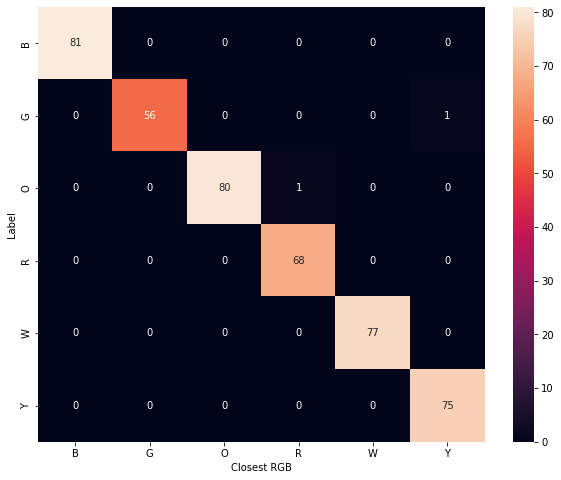

In [ ]:
def predict_and_summarize(X, Y):
    model = load_model(f'{model_name}', compile=False)
    Y_pred = tf.argmax(model.predict(X), axis = 1)
    confusion_matrix(tf.argmax(Y, axis = 1), Y_pred)
    return Y_pred

n_tests = len(testing_file_list)
X_test, y_test = next(image_data_generator(testing_file_list, testing_labels, n_tests))

y_pred = predict_and_summarize(X_test, y_test)
test_true_label = tf.argmax(y_test, axis = 1)


<Figure size 432x288 with 0 Axes>

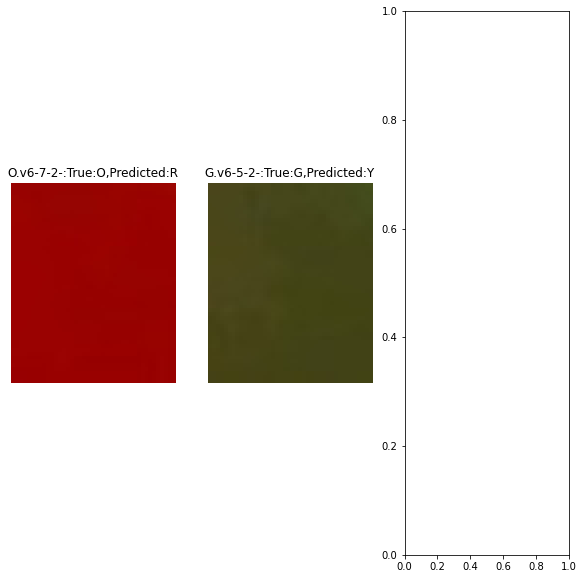

In [ ]:
show_diff(test_true_label, y_pred)

# Decision Tree model

In [6]:
from sklearn import tree
from sklearn.tree import export_text
from joblib import dump, load

In [7]:
# Convert image to dominant color HSV and label
def get_dominant_bgr(img):
  average = img.mean(axis=0).mean(axis=0)
  pixels = np.float32(img.reshape(-1, 3))

  n_colors = 1
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
  flags = cv2.KMEANS_RANDOM_CENTERS
  _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
  _, counts = np.unique(labels, return_counts=True)
  # dominant BGR
  (b, g, r) = palette[np.argmax(counts)]
  return (b, g, r)

def get_dominant_hsv(img):
  average = img.mean(axis=0).mean(axis=0)
  pixels = np.float32(img.reshape(-1, 3))

  n_colors = 1
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
  flags = cv2.KMEANS_RANDOM_CENTERS
  _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
  _, counts = np.unique(labels, return_counts=True)
  # dominant BGR
  (b, g, r) = palette[np.argmax(counts)]
  
  # convert BGR to HSV
  (h, s, v) = colorsys.rgb_to_hsv(r/255, g/255, b/255)
  return (h * 360, s * 100, v * 100)

def generate_input_vector(file_list):
  inputs = []
  outputs = []
  for f in file_list:
    img = cv2.imread(f)
    (h, s, v) = get_dominant_hsv(img)

    label = os.path.basename(f).split('.')[0]
    inputs.append([h, s, v])
    if label in colors:
      outputs.append(colors.index(label))
    else:
      outputs.append('')
  return (inputs, outputs)

(inputs, outputs) = generate_input_vector(training_file_list)

In [8]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(inputs, outputs)


dump(clf, os.path.join(model_dir, dt_model_name))

['/content/gdrive/My Drive/Colab Notebooks/Rubic cube color classification/models/decision_tree-v4-7.joblib']

In [9]:
clf = load(os.path.join(model_dir, dt_model_name))
# test on test set
(test_inputs, test_outputs) = generate_input_vector(testing_file_list)
predicts = clf.predict(test_inputs)

print(export_text(clf))


|--- feature_0 <= 174.84
|   |--- feature_0 <= 86.26
|   |   |--- feature_0 <= 36.05
|   |   |   |--- feature_0 <= 3.52
|   |   |   |   |--- feature_0 <= 1.10
|   |   |   |   |   |--- feature_1 <= 44.54
|   |   |   |   |   |   |--- class: 4
|   |   |   |   |   |--- feature_1 >  44.54
|   |   |   |   |   |   |--- feature_0 <= 0.56
|   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |   |--- feature_0 >  0.56
|   |   |   |   |   |   |   |--- feature_1 <= 99.59
|   |   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |   |   |--- feature_1 >  99.59
|   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |--- feature_0 >  1.10
|   |   |   |   |   |--- feature_1 <= 99.59
|   |   |   |   |   |   |--- feature_1 <= 45.14
|   |   |   |   |   |   |   |--- class: 4
|   |   |   |   |   |   |--- feature_1 >  45.14
|   |   |   |   |   |   |   |--- feature_1 <= 99.16
|   |   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |   |   |--- feature_1 >  99.16
|   |   |   

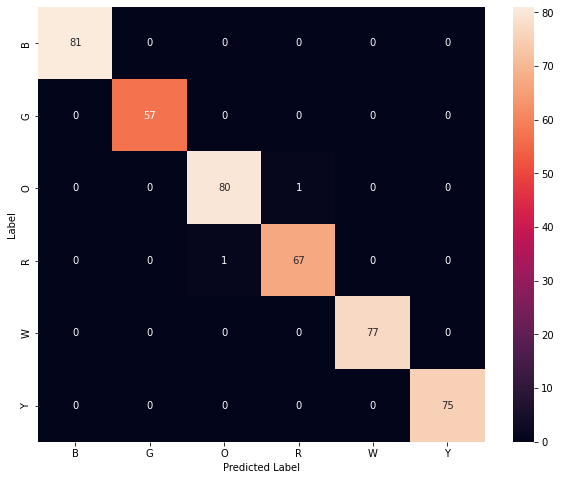

In [10]:
confusion_mtx = tf.math.confusion_matrix(test_outputs, predicts)
plt.figure(figsize=(10, 8)),
sns.heatmap(confusion_mtx,
            xticklabels=colors,
            yticklabels=colors,
            annot=True, fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('Label')
plt.show()

<Figure size 432x288 with 0 Axes>

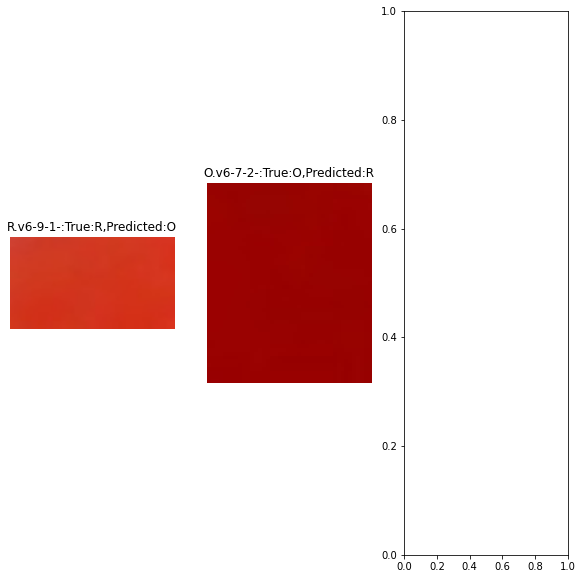

In [11]:
show_diff(test_outputs, predicts)

# Closest Color

In [ ]:
# Calculate average color
def calculate_average_color(file_list):
  color_vec = {}
  for f in training_file_list:
    col = os.path.basename(f).split('.')[0]
    img = cv2.imread(f)
    (b, g, r) = get_dominant_bgr(img)
    color_vec.setdefault(col, []).append((b, g, r))
  
  avg_color = {}
  for col in color_vec:
    rgb_vec = (0, 0, 0)
    num = len(color_vec[col])
    for rgb in color_vec[col]:
      rgb_vec = tuple(map(sum, zip(rgb_vec, rgb)))
    (b, g, r) = rgb_vec
    avg_color[col] = (b / num, g / num, r / num)
  return avg_color
  
avg_color = calculate_average_color(training_file_list)
for col in avg_color:
  (b, g, r) = avg_color[col]
  print('{}:({}, {}, {})'.format(col, b, g, r))

W:(211.3336335846055, 185.0930101644024, 188.0548500896764)
R:(11.021052486623624, 11.70875581743336, 165.5496612966877)
Y:(87.2141326567583, 210.90845800031695, 198.49897592109545)
B:(184.1040568197927, 88.39749349231788, 8.894189647662596)
G:(108.67517968294251, 165.9749808358674, 58.46157417143925)
O:(15.812478064742994, 89.76469682279881, 212.92808811638946)


In [ ]:
def bgr2lab(inputColor):
    """Convert BGR to LAB."""
    # Convert BGR to RGB
    inputColor = (inputColor[2], inputColor[1], inputColor[0])

    num = 0
    RGB = [0, 0, 0]

    for value in inputColor:
         value = float(value) / 255

         if value > 0.04045:
              value = ( ( value + 0.055 ) / 1.055 ) ** 2.4
         else:
              value = value / 12.92

         RGB[num] = value * 100
         num = num + 1

    XYZ = [0, 0, 0,]

    X = RGB [0] * 0.4124 + RGB [1] * 0.3576 + RGB [2] * 0.1805
    Y = RGB [0] * 0.2126 + RGB [1] * 0.7152 + RGB [2] * 0.0722
    Z = RGB [0] * 0.0193 + RGB [1] * 0.1192 + RGB [2] * 0.9505
    XYZ[ 0 ] = round( X, 4 )
    XYZ[ 1 ] = round( Y, 4 )
    XYZ[ 2 ] = round( Z, 4 )

    XYZ[ 0 ] = float( XYZ[ 0 ] ) / 95.047            # ref_X =  95.047    Observer= 2°, Illuminant= D65
    XYZ[ 1 ] = float( XYZ[ 1 ] ) / 100.0             # ref_Y = 100.000
    XYZ[ 2 ] = float( XYZ[ 2 ] ) / 108.883          # ref_Z = 108.883

    num = 0
    for value in XYZ:

         if value > 0.008856:
              value = value ** ( 0.3333333333333333 )
         else :
              value = ( 7.787 * value ) + ( 16 / 116 )

         XYZ[num] = value
         num = num + 1

    Lab = [0, 0, 0]

    L = ( 116 * XYZ[ 1 ] ) - 16
    a = 500 * ( XYZ[ 0 ] - XYZ[ 1 ] )
    b = 200 * ( XYZ[ 1 ] - XYZ[ 2 ] )

    Lab [ 0 ] = round( L, 4 )
    Lab [ 1 ] = round( a, 4 )
    Lab [ 2 ] = round( b, 4 )

    return Lab

# Copyright to https://github.com/lovro-i/CIEDE2000.
def ciede2000(Lab_1, Lab_2):
    """Calculates CIEDE2000 color distance between two CIE L*a*b* colors."""
    C_25_7 = 6103515625 # 25**7

    L1, a1, b1 = Lab_1[0], Lab_1[1], Lab_1[2]
    L2, a2, b2 = Lab_2[0], Lab_2[1], Lab_2[2]
    C1 = math.sqrt(a1**2 + b1**2)
    C2 = math.sqrt(a2**2 + b2**2)
    C_ave = (C1 + C2) / 2
    G = 0.5 * (1 - math.sqrt(C_ave**7 / (C_ave**7 + C_25_7)))

    L1_, L2_ = L1, L2
    a1_, a2_ = (1 + G) * a1, (1 + G) * a2
    b1_, b2_ = b1, b2

    C1_ = math.sqrt(a1_**2 + b1_**2)
    C2_ = math.sqrt(a2_**2 + b2_**2)

    if b1_ == 0 and a1_ == 0: h1_ = 0
    elif a1_ >= 0: h1_ = math.atan2(b1_, a1_)
    else: h1_ = math.atan2(b1_, a1_) + 2 * math.pi

    if b2_ == 0 and a2_ == 0: h2_ = 0
    elif a2_ >= 0: h2_ = math.atan2(b2_, a2_)
    else: h2_ = math.atan2(b2_, a2_) + 2 * math.pi

    dL_ = L2_ - L1_
    dC_ = C2_ - C1_
    dh_ = h2_ - h1_
    if C1_ * C2_ == 0: dh_ = 0
    elif dh_ > math.pi: dh_ -= 2 * math.pi
    elif dh_ < -math.pi: dh_ += 2 * math.pi
    dH_ = 2 * math.sqrt(C1_ * C2_) * math.sin(dh_ / 2)

    L_ave = (L1_ + L2_) / 2
    C_ave = (C1_ + C2_) / 2

    _dh = abs(h1_ - h2_)
    _sh = h1_ + h2_
    C1C2 = C1_ * C2_

    if _dh <= math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2
    elif _dh  > math.pi and _sh < 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 + math.pi
    elif _dh  > math.pi and _sh >= 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 - math.pi
    else: h_ave = h1_ + h2_

    T = 1 - 0.17 * math.cos(h_ave - math.pi / 6) + 0.24 * math.cos(2 * h_ave) + 0.32 * math.cos(3 * h_ave + math.pi / 30) - 0.2 * math.cos(4 * h_ave - 63 * math.pi / 180)

    h_ave_deg = h_ave * 180 / math.pi
    if h_ave_deg < 0: h_ave_deg += 360
    elif h_ave_deg > 360: h_ave_deg -= 360
    dTheta = 30 * math.exp(-(((h_ave_deg - 275) / 25)**2))

    R_C = 2 * math.sqrt(C_ave**7 / (C_ave**7 + C_25_7))
    S_C = 1 + 0.045 * C_ave
    S_H = 1 + 0.015 * C_ave * T

    Lm50s = (L_ave - 50)**2
    S_L = 1 + 0.015 * Lm50s / math.sqrt(20 + Lm50s)
    R_T = -math.sin(dTheta * math.pi / 90) * R_C

    k_L, k_C, k_H = 1, 1, 1

    f_L = dL_ / k_L / S_L
    f_C = dC_ / k_C / S_C
    f_H = dH_ / k_H / S_H

    dE_00 = math.sqrt(f_L**2 + f_C**2 + f_H**2 + R_T * f_C * f_H)
    return dE_00

In [ ]:
def get_closest_color(avg_color, bgr):
    """
    Get the closest color of a BGR color using CIEDE2000 distance.
    :param bgr tuple: The BGR color to use.
    :returns: dict
    """
    lab = bgr2lab(bgr)
    distances = []
    for color_name, color_bgr in avg_color.items():
        distances.append({
            'color_name': color_name,
            'color_bgr': color_bgr,
            'distance': ciede2000(lab, bgr2lab(color_bgr))
        })
    closest = min(distances, key=lambda item: item['distance'])
    return closest['color_name']

closest = get_closest_color(avg_color, (24, 79, 168))
print(closest)

O


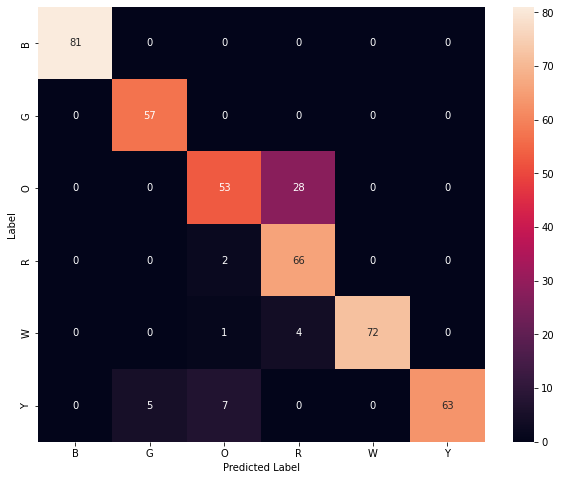

In [ ]:
def test_closest_color(file_list):
  true_color = []
  closest_color = []
  for f in file_list:
    true_color.append(colors.index(os.path.basename(f).split('.')[0]))
    
    img = cv2.imread(f)
    bgr = get_dominant_bgr(img)
    closest = get_closest_color(avg_color, bgr)
    closest_color.append(colors.index(closest))
  return(true_color, closest_color)
  
(true_color, closest_color) = test_closest_color(testing_file_list)
confusion_mtx = tf.math.confusion_matrix(true_color, closest_color)
plt.figure(figsize=(10, 8)),
sns.heatmap(confusion_mtx,
            xticklabels=colors,
            yticklabels=colors,
            annot=True, fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('Label')
plt.show()

<Figure size 432x288 with 0 Axes>

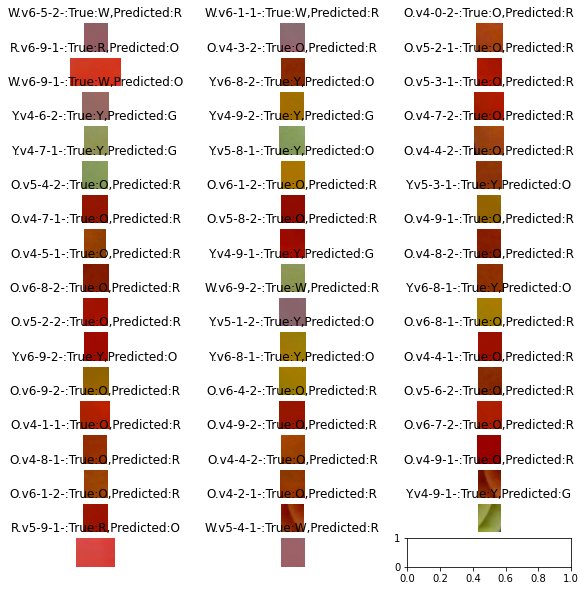

In [ ]:
show_diff(np.array(true_color), np.array(closest_color))

# Test Full Picture

In [12]:
test_dir = os.path.join(local_data_dir, 'pictures')
print(test_dir)
if pathlib.Path(test_dir).exists():
  shutil.rmtree(test_dir)
shutil.copytree(os.path.join(base_drive_dir, 'full pictures', version + '-test'), test_dir)


data/pictures


'data/pictures'

In [13]:
polygons = {
            "U1":  (887.9120879120879, 247.9120879120879,59.78021978021978,33.40659340659341),
            "U2": (1025.054945054945,274.2857142857143,45.714285714285715,36.92307692307692), 
            "U3": (1169.2307692307693,312.96703296703294,52.747252747252745,36.92307692307692), 
            "U4":(764.8351648351648,283.0769230769231,61.53846153846154,35.16483516483517), 
            "U5":(907.2527472527472,327.032967032967,58.02197802197802,36.92307692307692), 
            "U6":(1053.1868131868132,370.989010989011,65.05494505494505,42.1978021978022), 
            "U7":(606.5934065934066,339.34065934065933,56.26373626373626,42.1978021978022), 
            "U8":(743.7362637362637,381.53846153846155,59.78021978021978,42.1978021978022), 
            "U9":(903.7362637362637,434.2857142857143,70.32967032967034,49.230769230769226), 
            "L1":(546.8131868131868,436.04395604395603,49.230769230769226,47.472527472527474), 
            "L2":(669.8901098901099,501.0989010989011,50.989010989010985,59.78021978021978), 
            "L3":(800,564.3956043956044,56.26373626373626,59.78021978021978), 
            "L4":(594.2857142857142,606.5934065934066,45.714285714285715,50.989010989010985), 
            "L5":(699.7802197802198,678.6813186813187,45.714285714285715,58.02197802197802), 
            "L6":(826.3736263736264,764.8351648351648,49.230769230769226,59.78021978021978), 
            "L7":(618.9010989010989,743.7362637362637,38.68131868131868,45.714285714285715), 
            "L8":(719.1208791208791,821.0989010989011,42.1978021978022,50.989010989010985), 
            "L9":(831.6483516483516,912.5274725274725,47.472527472527474,52.747252747252745), 
            "R1":(995.1648351648352,587.2527472527472,49.230769230769226,59.78021978021978), 
            "R2":(1146.3736263736264,501.0989010989011,50.989010989010985,61.53846153846154), 
            "R3":(1269.4505494505495,420.2197802197802,43.956043956043956,58.02197802197802), 
            "R4":(986.3736263736264,782.4175824175824,50.989010989010985,58.02197802197802), 
            "R5":(1141.098901098901,685.7142857142857,42.1978021978022,52.747252747252745), 
            "R6":(1243.076923076923,589.0109890109891,42.1978021978022,50.989010989010985), 
            "R7":(991.6483516483516,938.9010989010989,43.956043956043956,52.747252747252745), 
            "R8":(1123.5164835164835,822.8571428571429,42.1978021978022,47.472527472527474), 
            "R9":(1221.978021978022,734.945054945055,40.43956043956044,45.714285714285715)
        }

['B', 'G', 'O', 'R', 'W', 'Y']
U1 (214.09037746299154, 82.66062690776756, 50.9397918102788)
U2 (220.25586996094037, 24.178317378594148, 72.47920616000306)
U3 (132.91397884025955, 68.5452705563703, 67.69175809972427)
U4 (357.98743800789003, 91.30831383016618, 48.337219836665135)
U5 (13.876714383595809, 94.4045722122987, 67.49867757161458)
U6 (357.56051479637796, 90.14641149634623, 51.49881400314031)
U7 (207.3575508827127, 97.21914602737436, 59.46595435049019)
U8 (73.292772917178, 95.18234293774587, 74.64566099877452)
U9 (130.8260489888906, 72.05742521482524, 68.09786329082415)
L1 (60.0, 100.0, 100.0)
L2 (200.10232282210953, 99.92321408599024, 99.97321633731617)
L3 (0.0, 0.0, 100.00000598383885)
L4 (36.5592261267511, 99.87876557782853, 99.96406106387867)
L5 (57.4126956257806, 98.53189163710887, 98.23662252987133)
L6 (359.4915907153902, 99.96310259000849, 99.77591121897979)
L7 (88.7842278203517, 0.005463447888017109, 99.99628403607537)
L8 (94.65704532893744, 58.87532161692053, 99.93006089

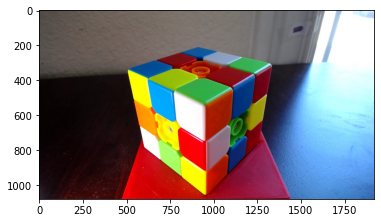

In [17]:
#clf = load(os.path.join(model_dir, 'decision_tree.joblib'))

def get_predicts_and_labels_with_cnn(model, img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  
  labels = []
  predicts = []
  for label in polygons:
    (x, y, width, height) = polygons[label]
    rect = img[round(y):round(y)+round(height), round(x):round(x)+round(width)]
    rect = cv2.resize(rect, (img_width, img_height))
    resized = tf.reshape(rect, [-1, 96, 96, 3])
    labels.append(label)
    predict = model.predict(resized)
    predicts.append(np.argmax(predict))
  return (labels, predicts)

def get_predicts_and_labels(model, img_path):
  img = cv2.imread(img_path)
  
  labels = []
  inputs = []
  predicts = []
  for label in polygons:
    labels.append(label)
    (x, y, width, height) = polygons[label]
    rect = img[round(y):round(y)+round(height), round(x):round(x)+round(width)]
    (h, s, v) = get_dominant_hsv(rect)
    print(label, (h, s, v))
    inputs.append([h, s, v])
  predicts = model.predict(inputs)
  return (labels, predicts)


def test_full_picture(model, img_path):
  plt.imshow(Image.open(img_path))
  #(labels, predicts) = get_predicts_and_labels_with_cnn(model, img_path)
  (labels, predicts) = get_predicts_and_labels(clf, img_path)
  label_to_predict = {}
  for i in range(len(labels)):
    #print('{}:{}'.format(labels[i], colors[tf.argmax(predicts[i], axis = 1)[0]]), predicts[i])
    #print('"{}":[{}],'.format(labels[i], ','.join('%0.4f' % x for x in predicts[i][0])))
    print('{}:{}'.format(labels[i], colors[predicts[i]], predicts[i]))
    label_to_predict[labels[i]] = predicts[i]
  return label_to_predict

print(colors)
model = load_model(f'{model_name}', compile=False)
label_to_predict = test_full_picture(model, os.path.join(test_dir, '0-2.jpg'))

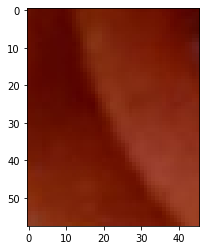

In [ ]:
def show_rect(img_path, label):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  (x, y, width, height) = polygons[label]
  rect = img[round(y): round(y)+ round(height), round(x): round(x) + round(width)]
  plt.imshow(rect)


show_rect(os.path.join(test_dir, '0-1.jpg'), 'L5')

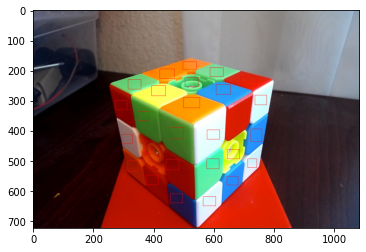

In [ ]:
def show_polygons(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  for label in polygons:
    (x, y, width, height) = polygons[label]
    cv2.rectangle(img, (x, y), (x + width, y + height), (255, 0, 0))
  plt.imshow(img)
show_polygons(os.path.join(test_dir, 'test-1-1.jpg'))